# Localization

Use "localization" to learn a Cahn-Hilliard model.


## Learn a Cahn-Hilliard

Square domain periodic boundary conditions

## $$ \dot{\phi} = \nabla^2 \left( \phi^3 - \phi \right) - \gamma \nabla^4 \phi $$

## What are we trying to do?

Create a mapping from $t_0$ to $t_{10}$ without doing all the steps. We want to do the following.

## $$ \phi[s](t=t_0) \rightarrow \phi[s](t=t_{10})$$

## Localization

Use regression for each local state.

## Create Samples

In [1]:
%matplotlib inline

import pymks
import matplotlib.pyplot as plt
import numpy as np
from pymks.datasets import make_cahn_hilliard

In [2]:
n_steps = 10
size = (151, 151)
X, y = make_cahn_hilliard(n_samples=10, size=size, dt=1., n_steps=n_steps)

In [3]:
print(X.shape)
print(y.shape)

(10, 151, 151)
(10, 151, 151)


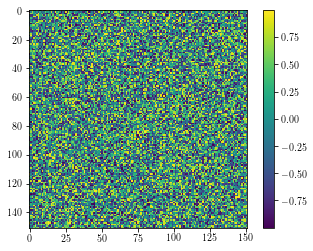

In [4]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(X[0])
plt.colorbar()

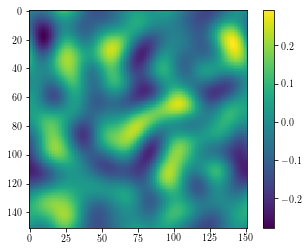

In [5]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y[0])
plt.colorbar()

## Parallel

In [6]:
from dask import compute, delayed
import dask.multiprocessing

def make_data(seed):
    np.random.seed(seed)
    return make_cahn_hilliard(n_samples=10, size=size, dt=1., n_steps=n_steps)

funcs = [delayed(make_data)(seed) for seed in range(30)]
    
out = compute(*funcs, get=dask.multiprocessing.get)


In [7]:
np.array(out).shape

(30, 2, 10, 151, 151)

In [8]:
X = np.array(out)[:, 0].reshape((300,) + size)
y = np.array(out)[:, 1].reshape((300,) + size)

## Learning

In [9]:
from pymks import MKSLocalizationModel
from pymks.bases import PrimitiveBasis

basis = PrimitiveBasis(n_states=5, domain=[-1, 1])
model = MKSLocalizationModel(basis=basis)

In [10]:
model.fit(X[:-1], y[:-1])

In [11]:
y_pred = model.predict(X[-1:])

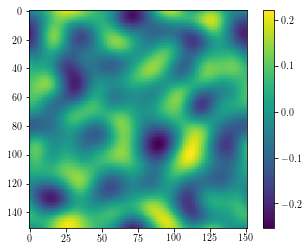

In [12]:
# NBVAL_IGNORE_OUTPUT
plt.imshow(y_pred[0])
plt.colorbar()

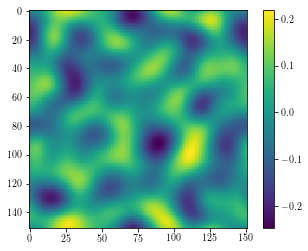

In [13]:
# NBVAL_IGNORE_OUTPUT
plt.imshow(y[-1])
plt.colorbar()

## Train Test Split

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
basis = PrimitiveBasis(n_states=5, domain=[-1, 1])
model = MKSLocalizationModel(basis=basis)

In [16]:
model.fit(X_train, y_train)

In [17]:
y_pred = model.predict(X_test)

In [18]:
# NBVAL_IGNORE_OUTPUT

metrics.mean_squared_error(y_pred.flatten(), y_test.flatten())

2.166521712273052e-06

In [19]:
# NBVAL_IGNORE_OUTPUT

print(y_pred[0][0][:10])
print(y_test[0][0][:10])

[ 0.00916141  0.02314393  0.03762101  0.05231096  0.06689219  0.08101386
  0.09430891  0.10640893  0.11695979  0.12563723]
[ 0.01020241  0.02422307  0.03875522  0.05351166  0.0681639   0.08235429
  0.09571072  0.10786256  0.11845671  0.12717269]


In [20]:
y_pred.shape

(75, 151, 151)

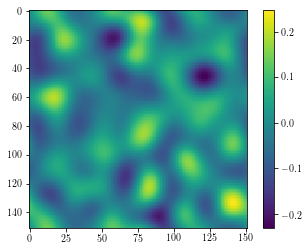

In [21]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y_pred[0])
plt.colorbar()

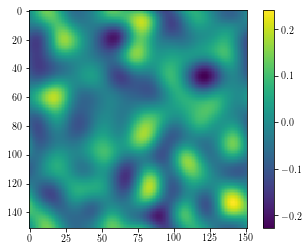

In [22]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y_test[0])
plt.colorbar()

## Scale Up

In [23]:
X_big, y_big = make_cahn_hilliard(n_samples=1, size=(1000, 1000), dt=1., n_steps=n_steps)

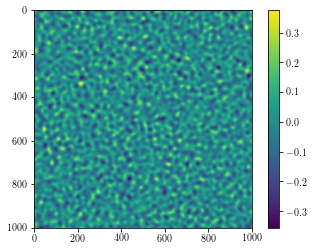

In [24]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y_big[0])
plt.colorbar()

In [25]:
basis = PrimitiveBasis(n_states=5, domain=[-1, 1])
model = MKSLocalizationModel(basis=basis)
model.fit(X, y)
model.resize_coeff(y_big[0].shape)

In [26]:
y_big_pred = model.predict(X_big)

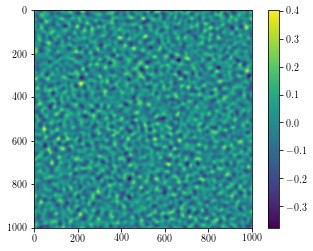

In [27]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y_big_pred[0])
plt.colorbar()

In [28]:
# NBVAL_IGNORE_OUTPUT

metrics.mean_squared_error(y_big_pred.flatten(), y_big.flatten())

2.2248058360466417e-06

In [29]:
# NBVAL_IGNORE_OUTPUT

%timeit make_cahn_hilliard(n_samples=1, size=(1000, 1000), dt=1., n_steps=n_steps)

2.65 s ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
# NBVAL_IGNORE_OUTPUT

%timeit model.predict(X_big)

249 ms ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Multiple Steps

In [31]:
X2, y2 = make_cahn_hilliard(n_samples=1, size=size, dt=1., n_steps=2 * n_steps)

basis = PrimitiveBasis(n_states=10, domain=[-1, 1])
model = MKSLocalizationModel(basis=basis)
model.fit(X, y)

In [32]:
tmp = model.predict(X2)
y2_pred = model.predict(tmp)

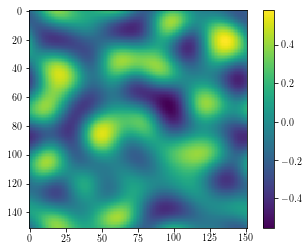

In [33]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y2[0])
plt.colorbar()

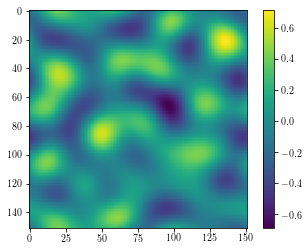

In [34]:
# NBVAL_IGNORE_OUTPUT

plt.imshow(y2_pred[0])
plt.colorbar()

In [35]:
# NBVAL_IGNORE_OUTPUT

metrics.mean_squared_error(y2_pred.flatten(), y2.flatten())

0.0003718054458280288

## Cross Validation

In [ ]:
from pymks.bases import LegendreBasis
from sklearn.model_selection import GridSearchCV
from dask_searchcv import GridSearchCV
from sklearn import metrics
mse = metrics.mean_squared_error

prim_basis = PrimitiveBasis(2, [-1, 1])
leg_basis = LegendreBasis(2, [-1, 1])

params_to_tune = {'n_states': [2, 3, 5, 8, 13],
                  'basis': [prim_basis, leg_basis]}
model = MKSLocalizationModel(prim_basis)
score_func = metrics.make_scorer(lambda x, y: -mse(x.flatten(), y.flatten()))
gscv = GridSearchCV(model, params_to_tune, cv=5, scoring=score_func)

In [ ]:
# NBVAL_SKIP

gscv.fit(X_train, y_train)

In [ ]:
# NBVAL_SKIP

gscv.best_estimator_

In [ ]:
# NBVAL_SKIP

gscv.score(X_test, y_test)

In [ ]:
# NBVAL_SKIP

gscv.cv_results_